# Setup and initial correlogram

Data Preview:
   Unnamed: 0                                      col_name  Présent  \
0           0         1954_San-Antonio_Messieurs-les-hommes     4770   
1           1      1957_Pagnol-Marcel_La-Gloire-de-mon-pere     3049   
2           2           1957_Simenon-Georges_Maigret-voyage     2393   
3           3  1845_Balzac-Honore-de_L-Elixir-de-longue-vie      388   
4           4                     1884_Halt-Robert_Marianne     2741   

   Imparfait  Passé simple  Passé composé  Futur  Plus que parfait        date  
0        165            11            481     80                20  1954-01-01  
1       1348           848            359    103               206  1957-01-01  
2       1227           440            654     61               195  1957-01-01  
3        189           194             48     21                24  1845-01-01  
4       1357          1397            455    157               180  1884-01-01  

Available Years in Data: [1811, 1812, 1815, 1816, 1817, 1819, 1821

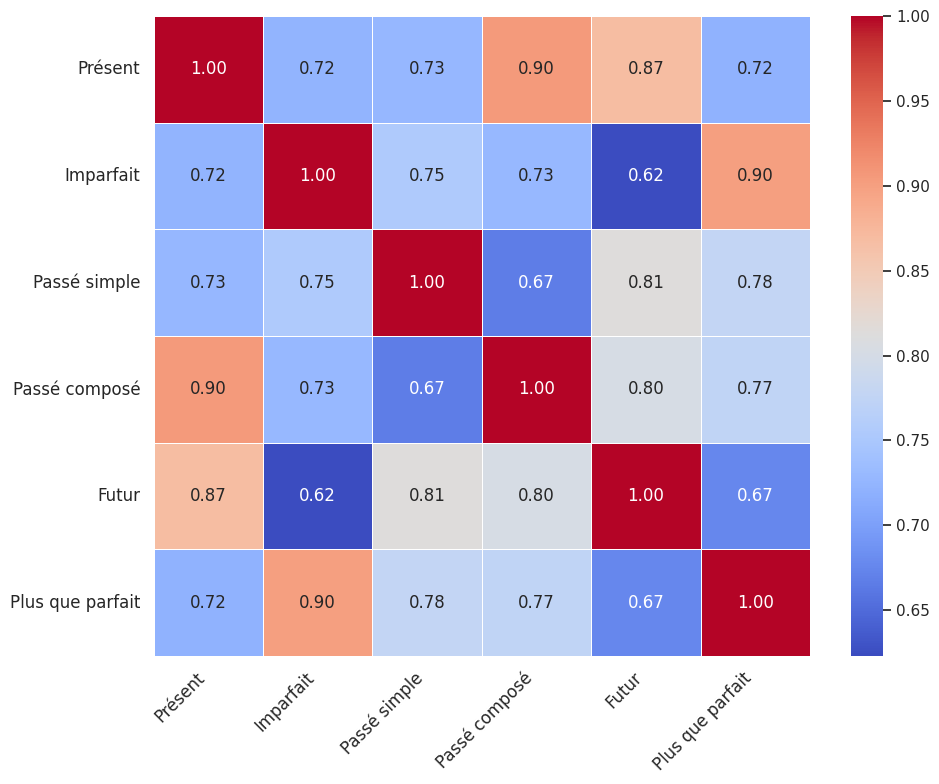


Yearly Correlations Before Smoothing:
   Year   Présent  Imparfait  Passé composé     Futur  Plus que parfait
0  1811       NaN        NaN            NaN       NaN               NaN
1  1812       NaN        NaN            NaN       NaN               NaN
2  1815 -1.000000   1.000000      -1.000000 -1.000000          1.000000
3  1816  0.701559  -0.921542      -0.529355  0.870742         -0.867918
4  1817  0.811585   0.816212       0.958967 -0.741754         -0.831904

Yearly Correlations After Smoothing:
   Year   Présent  Imparfait  Passé composé     Futur  Plus que parfait
0  1811 -0.185492   0.154065      -0.361336 -0.161323          0.161726
1  1812  0.073306   0.127810      -0.081484 -0.124430         -0.099975
2  1815  0.214751   0.268817       0.038931 -0.016394          0.041718
3  1816  0.214751   0.268817       0.038931 -0.016394          0.041718
4  1817  0.357257   0.411351       0.180910  0.125751          0.183744


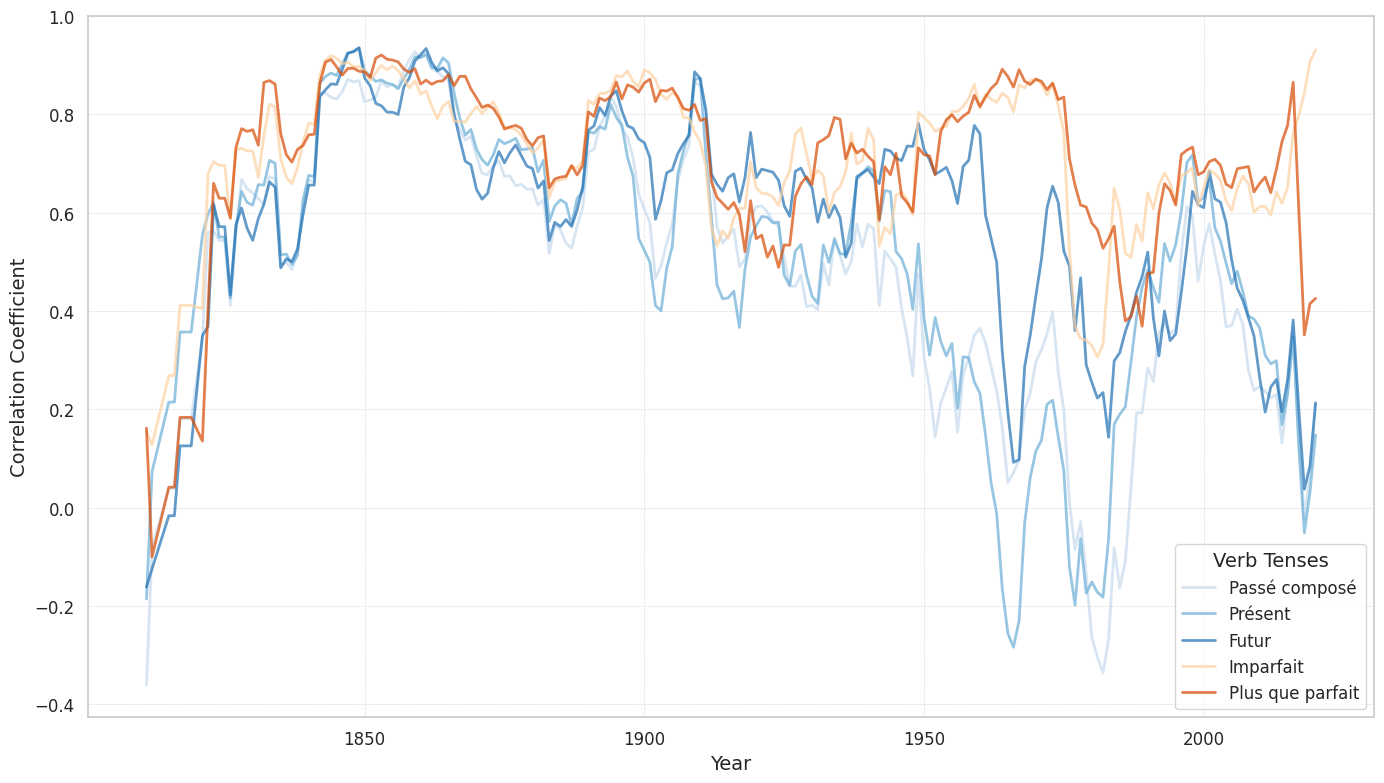



Percentage Usage of Verb Tenses per Year:
   Year  Présent  Imparfait  Passé simple  Passé composé  Futur  \
0  1811     8876       2197          1813           1918    261   
1  1812     3950       1038          1069            517    188   
2  1815     3400       1164          1187            498    110   
3  1816    15129       3267          6811           2552    971   
4  1817     5206       1523          1529           1015    322   

   Plus que parfait  Total  Présent_perc  Imparfait_perc  Passé simple_perc  \
0               486  15551     57.076715       14.127709          11.658414   
1               216   6978     56.606478       14.875322          15.319576   
2               279   6638     51.220247       17.535402          17.881892   
3              1003  29733     50.882857       10.987791          22.907207   
4               534  10129     51.396979       15.036035          15.095271   

   Passé composé_perc  Futur_perc  Plus que parfait_perc  
0           12.3336

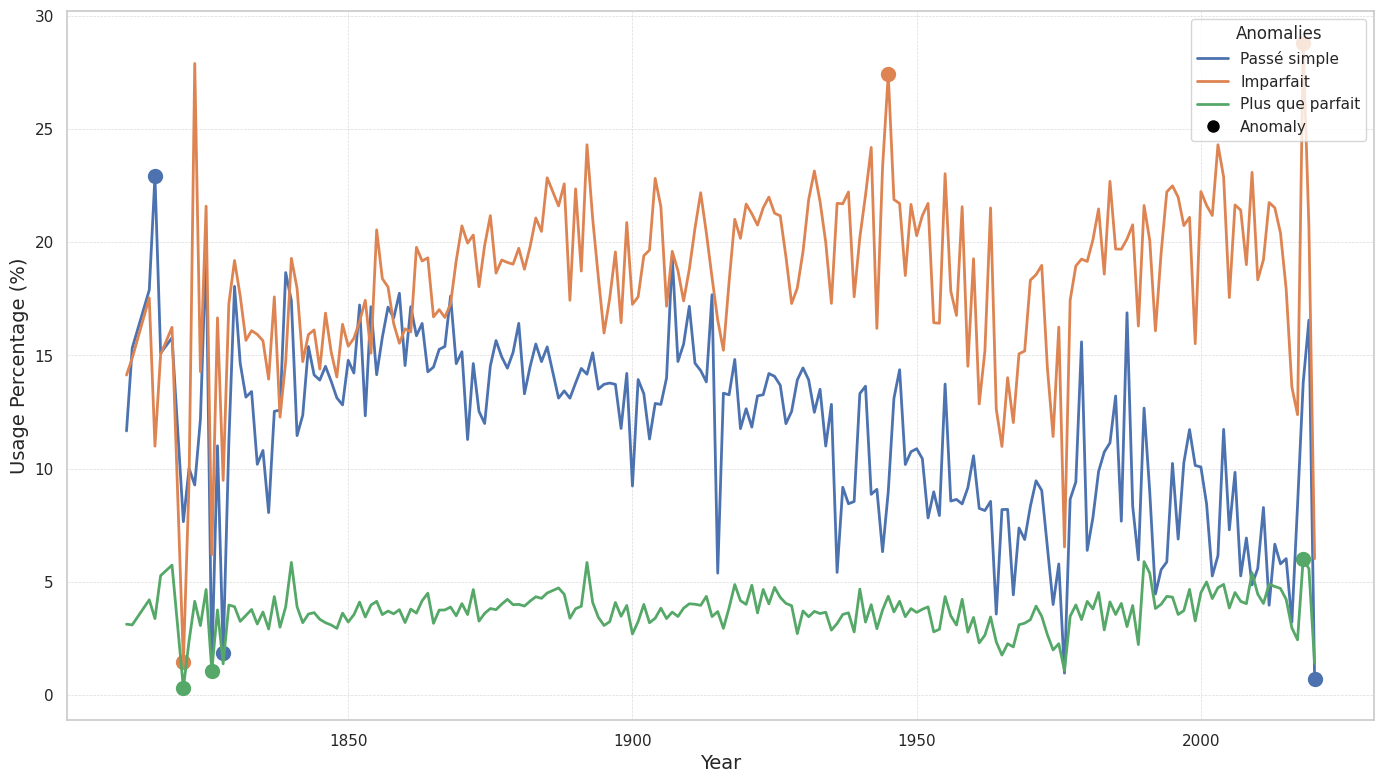

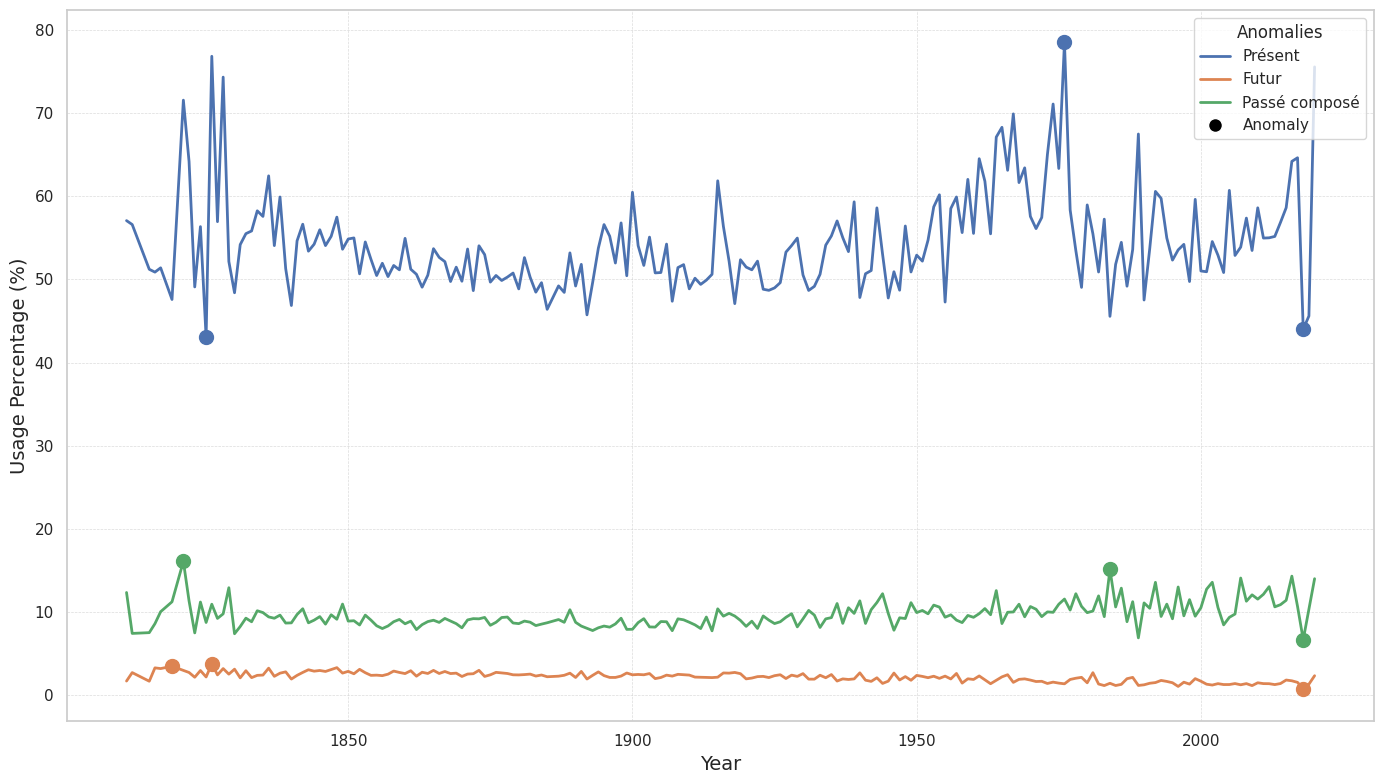

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import warnings

sns.set_theme(style="whitegrid")
%matplotlib inline
warnings.filterwarnings('ignore')

# Charger le jeu de données
data = pd.read_csv("DF_EVOL_TENSE_FLORIAN.csv")
print("Aperçu des données :")
print(data.head())

# Convertir 'date' au format datetime et extraire 'Year'
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['Year'] = data['date'].dt.year

# Supprimer les lignes avec des dates invalides
missing_years = data['Year'].isnull().sum()
if missing_years > 0:
    print(f"\nAttention : {missing_years} entrées ont des dates invalides et seront supprimées.")
    data = data.dropna(subset=['Year'])

data['Year'] = data['Year'].astype(int)
print("\nAnnées disponibles dans les données :", sorted(data['Year'].unique()))

# Définir les colonnes des temps verbaux
verb_tenses = ['Présent', 'Imparfait', 'Passé simple', 'Passé composé', 'Futur', 'Plus que parfait']
for tense in verb_tenses:
    if tense not in data.columns:
        raise ValueError(f"La colonne '{tense}' est manquante dans les données.")

# Calculer et tracer la matrice de corrélation
correlation_matrix = data[verb_tenses].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()





# Evolution of correlations between passé simple and other tenses

In [ ]:
# Calculer les corrélations annuelles
yearly_corr = pd.DataFrame({'Year': sorted(data['Year'].unique())})

for tense in verb_tenses:
    if tense != 'Passé simple':
        yearly_corr[tense] = np.nan

for year in yearly_corr['Year']:
    df_year = data[data['Year'] == year]
    for tense in verb_tenses:
        if tense == 'Passé simple':
            continue
        if df_year[tense].nunique() > 1 and df_year['Passé simple'].nunique() > 1:
            corr = df_year['Passé simple'].corr(df_year[tense])
        else:
            corr = np.nan
        yearly_corr.loc[yearly_corr['Year'] == year, tense] = corr

print("\nCorrélations annuelles avant lissage :")
print(yearly_corr.head())

# Appliquer un lissage
window_size = 7
for tense in verb_tenses:
    if tense == 'Passé simple':
        continue
    yearly_corr[tense] = uniform_filter1d(yearly_corr[tense].fillna(0), size=window_size)

print("\nCorrélations annuelles après lissage :")
print(yearly_corr.head())

# Définir les groupes de couleurs
group1_colors = sns.color_palette("Blues", n_colors=3)
group2_colors = sns.color_palette("Oranges", n_colors=3)

group1 = ['Passé composé', 'Présent', 'Futur']
group2 = ['Imparfait', 'Passé simple', 'Plus que parfait']

color_mapping = {tense: color for tense, color in zip(group1 + group2, group1_colors + group2_colors)}

# Fonction de traçage des corrélations lissées
def plot_smoothed_correlations(data, tenses, color_mapping, title=""):
    plt.figure(figsize=(14, 8))
    for tense in tenses:
        perc_col = tense
        if perc_col not in data.columns:
            continue
        plt.plot(
            data['Year'],
            data[perc_col],
            label=tense,
            color=color_mapping.get(tense, 'gray'),
            linewidth=2,
            alpha=0.7
        )
    plt.xlabel("Année", fontsize=14)
    plt.ylabel("Coefficient de corrélation", fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Temps verbaux", fontsize=12, title_fontsize=14, loc='best')
    plt.tight_layout()
    plt.show()

# Tracer les corrélations lissées
plot_smoothed_correlations(
    data=yearly_corr,
    tenses=group1 + group2,
    color_mapping=color_mapping,
    title=""
)

# Detection of ponctual anomalies





In [ ]:
# Agréger les données par année et calculer les pourcentages
aggregated_data = data.groupby('Year')[verb_tenses].sum().reset_index()
aggregated_data['Total'] = aggregated_data[verb_tenses].sum(axis=1)

zero_total_years = aggregated_data[aggregated_data['Total'] == 0]
if not zero_total_years.empty:
    print(f"\nAttention : {len(zero_total_years)} années ont un usage total de zéro et seront supprimées.")
    aggregated_data = aggregated_data[aggregated_data['Total'] != 0]

for tense in verb_tenses:
    aggregated_data[f'{tense}_perc'] = (aggregated_data[tense] / aggregated_data['Total']) * 100

percentage_columns = [f'{tense}_perc' for tense in verb_tenses]
aggregated_data.dropna(subset=percentage_columns, inplace=True)

print("\nPourcentage d'utilisation des temps verbaux par année :")
print(aggregated_data.head())

# Définir les groupes de verbes
group1 = ['Passé simple', 'Imparfait', 'Plus que parfait']
group2 = ['Présent', 'Futur', 'Passé composé']

# Créer les colonnes de pourcentage pour chaque groupe
group1_perc = [f'{tense}_perc' for tense in group1]
group2_perc = [f'{tense}_perc' for tense in group2]

# Fonction pour détecter les anomalies avec Isolation Forest
def detect_anomalies_isolation_forest(series, contamination=0.01, random_state=42):
    data_model = series.values.reshape(-1, 1)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_model)
    model = IsolationForest(contamination=contamination, random_state=random_state, n_estimators=100)
    model.fit(data_scaled)
    preds = model.predict(data_scaled)
    anomalies = np.where(preds == -1)[0]
    return anomalies

# Détecter les anomalies
anomalies_group1 = {tense: detect_anomalies_isolation_forest(aggregated_data[f'{tense}_perc']) for tense in group1}
anomalies_group2 = {tense: detect_anomalies_isolation_forest(aggregated_data[f'{tense}_perc']) for tense in group2}

print("\nAnomalies détectées pour le Groupe 1 :")
for tense, anomalies in anomalies_group1.items():
    anomaly_years = aggregated_data['Year'].iloc[anomalies].tolist()
    print(f"{tense} : {len(anomalies)} anomalies aux années {anomaly_years}")

print("\nAnomalies détectées pour le Groupe 2 :")
for tense, anomalies in anomalies_group2.items():
    anomaly_years = aggregated_data['Year'].iloc[anomalies].tolist()
    print(f"{tense} : {len(anomalies)} anomalies aux années {anomaly_years}")

# Fonction de traçage des usages avec anomalies
def plot_usage_with_anomalies(data, tenses, anomalies_dict, title=""):
    plt.figure(figsize=(14, 8))
    for tense in tenses:
        perc_col = f'{tense}_perc'
        line, = plt.plot(data['Year'], data[perc_col], label=tense, linewidth=2)
        anomalies = anomalies_dict.get(tense, [])
        if len(anomalies) > 0:
            anomaly_years = data['Year'].iloc[anomalies]
            anomaly_values = data[perc_col].iloc[anomalies]
            plt.scatter(anomaly_years, anomaly_values, color=line.get_color(), marker='o', s=100, label='_nolegend_')
    # Ajouter un marqueur pour les anomalies dans la légende
    anomaly_marker = Line2D([0], [0], marker='o', color='w', label='Anomalie',
                            markerfacecolor='black', markersize=10)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(anomaly_marker)
    labels.append('Anomalie')
    plt.legend(handles, labels, title="Anomalies", loc='upper right')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Année", fontsize=14)
    plt.ylabel("Pourcentage d'utilisation (%)", fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Tracer les pourcentages d'utilisation avec anomalies
plot_usage_with_anomalies(
    data=aggregated_data,
    tenses=group1,
    anomalies_dict=anomalies_group1,
    title=""
)

plot_usage_with_anomalies(
    data=aggregated_data,
    tenses=group2,
    anomalies_dict=anomalies_group2,
    title=""
)